In [26]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [1]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.
from pathlib import Path
import glob
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import random
import pickle
import os
import config
import data
import random
from natsort import natsorted
import lfp
arm = 'UR5'

TEST_DATASET = "UR5_slow_gripper_test" 
print('Using local setup')
WORKING_PATH = Path().absolute().parent
print(f'Working path: {WORKING_PATH}')
os.chdir(WORKING_PATH)
STORAGE_PATH = WORKING_PATH
print(f'Storage path: {STORAGE_PATH}')

TRAIN_DATA_PATHS = [STORAGE_PATH/'data'/x for x in ["UR5", "UR5_high_transition", "UR5_slow_gripper"]]
TEST_DATA_PATH = STORAGE_PATH/'data'/TEST_DATASET

Using local setup
Working path: /home/sholto/Desktop/AI/learning_from_play
Storage path: /home/sholto/Desktop/AI/learning_from_play


In [2]:
physical_devices = tf.config.list_physical_devices(config.DEVICE)
if config.DEVICE is 'GPU':
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
# 
RELATIVE = False # use relative joints instead of absolute pos/ori as in the original paper
QUAT =  False # whether to use quaternions or rpy in actions
JOINTS = False # use relative joints instead of absolute angles
VELOCITY = False
USE_QUAT_OBS = False

LAYER_SIZE = 2048
LATENT_DIM = LAYER_SIZE//8
GRIPPER_WEIGHT = 5.0
GCBC = False
PROBABILISTIC = False
QUANTISED = False
gripper_proprioception = False
arm = 'UR5'



In [31]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature


def transform_states(data):

  obs, acts, achieved_goals, joint_poses, target_poses, acts_quat, acts_rpy_rel, velocities, obs_quat, gripper_proprioception, sequence_index, sequence_id = data['obs'], data['acts'], data['achieved_goals'], data['joint_poses'], data['target_poses'], data['acts_quat'], data['acts_rpy_rel'], data['velocities'], data['obs_quat'], data['gripper_proprioception'], data['sequence_index'], data['sequence_id']
  
  img = tf.io.read_file(data['im_path'])
  #img = tf.io.decode_png(img, channels=3)

  return {
            'obs': obs,
            'acts': acts,
            'achieved_goals': achieved_goals,
            'joint_poses': joint_poses,
            'target_poses': target_poses,
            'acts_quat': acts_quat,
            'acts_rpy_rel': acts_rpy_rel,
            'velocities': velocities,
            'obs_quat': obs_quat,
            'gripper_proprioception': gripper_proprioception,
            'sequence_index': sequence_index,
            'sequence_id': sequence_id,
            'img':img,
            }

def transform_dataset(dataset):
  return dataset.map(transform_states, num_parallel_calls=4)


def serialise(data):
    
    obs, acts, achieved_goals, joint_poses, target_poses, acts_quat, acts_rpy_rel, velocities, obs_quat, gripper_proprioception, sequence_index, sequence_id, img = data['obs'], data['acts'], data['achieved_goals'], data['joint_poses'], data['target_poses'], data['acts_quat'], data['acts_rpy_rel'], data['velocities'], data['obs_quat'], data['gripper_proprioception'], data['sequence_index'], data['sequence_id'], data['img']
    
    #image_feature = Feature(bytes_list=BytesList(value=[tf.io.serialize_tensor(image).numpy(),]))
    
    obs = Feature(bytes_list=BytesList(value=[tf.io.serialize_tensor(obs).numpy(),]))
    acts = Feature(bytes_list=BytesList(value=[tf.io.serialize_tensor(acts).numpy(),]))
    achieved_goals = Feature(bytes_list=BytesList(value=[tf.io.serialize_tensor(achieved_goals).numpy(),])) 
    joint_poses = Feature(bytes_list=BytesList(value=[tf.io.serialize_tensor(joint_poses).numpy(),])) 
    target_poses = Feature(bytes_list=BytesList(value=[tf.io.serialize_tensor(target_poses).numpy(),]))
    acts_quat = Feature(bytes_list=BytesList(value=[tf.io.serialize_tensor(acts_quat).numpy(),]))
    acts_rpy_rel = Feature(bytes_list=BytesList(value=[tf.io.serialize_tensor(acts_rpy_rel).numpy(),])) 
    velocities = Feature(bytes_list=BytesList(value=[tf.io.serialize_tensor(velocities).numpy(),])) 
    obs_quat = Feature(bytes_list=BytesList(value=[tf.io.serialize_tensor(obs_quat).numpy(),]))
    gripper_proprioception = Feature(bytes_list=BytesList(value=[tf.io.serialize_tensor(gripper_proprioception).numpy(),])) 
    sequence_index =  Feature(int64_list=Int64List(value=[sequence_index,]))
    sequence_id = Feature(int64_list=Int64List(value=[sequence_id,]))
    img = Feature(bytes_list=BytesList(value=[img.numpy(),]))
    # img is already serialised because we never decode it!
    
    features = Features(feature={
                'obs': obs,
                'acts': acts,
                'achieved_goals': achieved_goals,
                'joint_poses': joint_poses,
                'target_poses': target_poses,
                'acts_quat': acts_quat,
                'acts_rpy_rel': acts_rpy_rel,
                'velocities': velocities,
                'obs_quat': obs_quat,
                'gripper_proprioception': gripper_proprioception,
                'sequence_index': sequence_index,
                'sequence_id': sequence_id,
                'img': img,
                })
    
    example = Example(features=features)
    
    return example.SerializeToString()


In [66]:
paths = TRAIN_DATA_PATHS
keys = ['obs','acts','achieved_goals','joint_poses','target_poses','acts_quat','acts_rpy_rel','velocities','obs_quat','gripper_proprioception']


for path in paths:
    obs_act_path = os.path.join(path, 'obs_act_etc/')
    
    try:
        os.makedirs(path/'tf_records')
    except:
        print('Files may already exist!')
        
    for demo in natsorted(os.listdir(obs_act_path)):
        print(obs_act_path+demo)
        dataset = {k:[] for k in keys+['sequence_index','sequence_id','im_path']}
        traj = np.load(obs_act_path+demo+'/data.npz')
        for k in keys:
            d = traj[k]
            if len(d.shape) < 2:
                d = np.expand_dims(d, axis = 1) # was N, should be N,1
            dataset[k] = d.astype(np.float32)
        timesteps = len(traj['obs'])
        dataset['sequence_index']= np.arange(timesteps, dtype=np.int32).reshape(-1, 1)
        dataset['sequence_id'] = np.full(timesteps, fill_value=int(demo), dtype=np.int32).reshape(-1, 1)
        dataset['im_path'] = [str(path) for i in range(0,timesteps)]
        dataset['im_path'] = [str(s) + '/states_and_ims/'+str(dataset['sequence_id'][i][0]) + '/ims/'+str(dataset['sequence_index'][i][0])+'.jpg' for i,s in enumerate(dataset['im_path'])]
        full_dataset = tf.data.Dataset.from_tensor_slices(dataset)
        full_dataset = transform_dataset(full_dataset)
        it = iter(full_dataset)
        # Write the records to a file.
        with tf.io.TFRecordWriter(str(path/'tf_records/')+f"/{demo}.tfrecords") as file_writer:
            for data in it:
                byte_stream = serialise(data)
                file_writer.write(byte_stream)


/home/sholto/Desktop/AI/learning_from_play/data/UR5/obs_act_etc/0
/home/sholto/Desktop/AI/learning_from_play/data/UR5/obs_act_etc/1
/home/sholto/Desktop/AI/learning_from_play/data/UR5/obs_act_etc/2
/home/sholto/Desktop/AI/learning_from_play/data/UR5/obs_act_etc/3
/home/sholto/Desktop/AI/learning_from_play/data/UR5/obs_act_etc/4
/home/sholto/Desktop/AI/learning_from_play/data/UR5/obs_act_etc/5
/home/sholto/Desktop/AI/learning_from_play/data/UR5/obs_act_etc/6
/home/sholto/Desktop/AI/learning_from_play/data/UR5/obs_act_etc/7
/home/sholto/Desktop/AI/learning_from_play/data/UR5/obs_act_etc/8
/home/sholto/Desktop/AI/learning_from_play/data/UR5/obs_act_etc/9
/home/sholto/Desktop/AI/learning_from_play/data/UR5/obs_act_etc/10
/home/sholto/Desktop/AI/learning_from_play/data/UR5/obs_act_etc/11
/home/sholto/Desktop/AI/learning_from_play/data/UR5/obs_act_etc/12
/home/sholto/Desktop/AI/learning_from_play/data/UR5/obs_act_etc/13
/home/sholto/Desktop/AI/learning_from_play/data/UR5/obs_act_etc/14
/home

In [118]:


 glob.glob(str(TEST_DATA_PATH/'states_and_ims'/str(4)/'env_states/*.bullet'))

In [67]:
record_paths = []
for p in TRAIN_DATA_PATHS:#[TEST_DATA_PATH]:
    record_paths += glob.glob(str(p/'tf_records/*.tfrecords'))
    
record_paths

['/home/sholto/Desktop/AI/learning_from_play/data/UR5/tf_records/19.tfrecords',
 '/home/sholto/Desktop/AI/learning_from_play/data/UR5/tf_records/8.tfrecords',
 '/home/sholto/Desktop/AI/learning_from_play/data/UR5/tf_records/28.tfrecords',
 '/home/sholto/Desktop/AI/learning_from_play/data/UR5/tf_records/13.tfrecords',
 '/home/sholto/Desktop/AI/learning_from_play/data/UR5/tf_records/6.tfrecords',
 '/home/sholto/Desktop/AI/learning_from_play/data/UR5/tf_records/51.tfrecords',
 '/home/sholto/Desktop/AI/learning_from_play/data/UR5/tf_records/30.tfrecords',
 '/home/sholto/Desktop/AI/learning_from_play/data/UR5/tf_records/41.tfrecords',
 '/home/sholto/Desktop/AI/learning_from_play/data/UR5/tf_records/23.tfrecords',
 '/home/sholto/Desktop/AI/learning_from_play/data/UR5/tf_records/3.tfrecords',
 '/home/sholto/Desktop/AI/learning_from_play/data/UR5/tf_records/44.tfrecords',
 '/home/sholto/Desktop/AI/learning_from_play/data/UR5/tf_records/27.tfrecords',
 '/home/sholto/Desktop/AI/learning_from_pla

In [84]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    #image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [200,200, 3]) # explicit size needed for TPU
    return image

def read_tfrecord(example):
    LABELED_TFREC_FORMAT = {
            'obs': tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
            'acts': tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
            'achieved_goals': tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
            'joint_poses': tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
            'target_poses': tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
            'acts_quat': tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
            'acts_rpy_rel': tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
            'velocities': tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
            'obs_quat': tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
            'gripper_proprioception': tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
            'sequence_index': tf.io.FixedLenFeature([], tf.int64),
            'sequence_id': tf.io.FixedLenFeature([], tf.int64),
            'img': tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
    }
    data = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    
    obs = tf.io.parse_tensor(data['obs'], tf.float32) 
    acts = tf.io.parse_tensor(data['acts'], tf.float32) 
    achieved_goals = tf.io.parse_tensor(data['achieved_goals'], tf.float32)  
    joint_poses = tf.io.parse_tensor(data['joint_poses'], tf.float32)  
    target_poses = tf.io.parse_tensor(data['target_poses'], tf.float32) 
    acts_quat =tf.io.parse_tensor( data['acts_quat'], tf.float32) 
    acts_rpy_rel = tf.io.parse_tensor(data['acts_rpy_rel'], tf.float32)  
    velocities = tf.io.parse_tensor(data['velocities'], tf.float32) 
    obs_quat = tf.io.parse_tensor(data['obs_quat'], tf.float32) 
    gripper_proprioception = tf.io.parse_tensor(data['gripper_proprioception'], tf.float32)  
    sequence_index = tf.cast(data['sequence_index'], tf.int32) 
    sequence_id = tf.cast(data['sequence_id'], tf.int32) # this is meant to be 32 even though you serialize as 64
    
    img = decode_image(data['img'])

    return {'obs' : obs, 
            'acts' : acts, 
            'achieved_goals' : achieved_goals, 
            'joint_poses' : joint_poses, 
            'target_poses' : target_poses, 
            'acts_quat' : acts_quat, 
            'acts_rpy_rel' : acts_rpy_rel, 
            'velocities' : velocities, 
            'obs_quat' : obs_quat, 
            'gripper_proprioception' : gripper_proprioception, 
            'sequence_index' : sequence_index, 
            'sequence_id' : sequence_id,
            'img' : img}

def load_tf_records(filenames, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    # check, does this ignore intra order or just inter order? Both are an issue!
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.experimental.AUTOTUNE) # automatically interleaves reads from multiple files - keep it at 1 we need the order
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

d =load_dataset([record_paths], ordered=True)#['/home/sholto/Desktop/AI/learning_from_play/data/UR5_high_transition/tf_records/21.tfrecords'], ordered=True) #record_paths
print(d)
d = iter(d)

<ParallelMapDataset shapes: {obs: <unknown>, acts: <unknown>, achieved_goals: <unknown>, joint_poses: <unknown>, target_poses: <unknown>, acts_quat: <unknown>, acts_rpy_rel: <unknown>, velocities: <unknown>, obs_quat: <unknown>, gripper_proprioception: <unknown>, sequence_index: (), sequence_id: (), img: (200, 200, 3)}, types: {obs: tf.float32, acts: tf.float32, achieved_goals: tf.float32, joint_poses: tf.float32, target_poses: tf.float32, acts_quat: tf.float32, acts_rpy_rel: tf.float32, velocities: tf.float32, obs_quat: tf.float32, gripper_proprioception: tf.float32, sequence_index: tf.int32, sequence_id: tf.int32, img: tf.float32}>


In [86]:
%%time
from IPython.display import display, clear_output
for i in range(0,10000):
    b = d.next()
    
    clear_output(wait=True)
    fig = plt.imshow(b['img'])
    plt.show()

KeyboardInterrupt: 

In [92]:
for i, (k,v) in enumerate(data.items()):
    print(v == b[i])
    

tf.Tensor(
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True], shape=(18,), dtype=bool)
tf.Tensor([ True  True  True  True  True  True  True], shape=(7,), dtype=bool)
tf.Tensor([ True  True  True  True  True  True  True  True  True  True  True], shape=(11,), dtype=bool)
tf.Tensor([ True  True  True  True  True  True  True  True], shape=(8,), dtype=bool)
tf.Tensor([ True  True  True  True  True  True], shape=(6,), dtype=bool)
tf.Tensor([ True  True  True  True  True  True  True  True], shape=(8,), dtype=bool)
tf.Tensor([ True  True  True  True  True  True  True], shape=(7,), dtype=bool)
tf.Tensor([ True  True  True  True  True  True], shape=(6,), dtype=bool)
tf.Tensor(
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True], shape=(19,), dtype=bool)
tf.Tensor([ True], shape=(1,), dtype=bool)
tf.Tensor([ True], shape=(1,), dtype=bool)
tf.Tensor([ True], shape=(1,), dty

InvalidArgumentError: cannot compute Equal as input #1(zero-based) was expected to be a string tensor but is a float tensor [Op:Equal]

In [94]:
obs, acts, achieved_goals, joint_poses, target_poses, acts_quat, acts_rpy_rel, velocities, obs_quat, gripper_proprioception, sequence_index, sequence_id,img = b 

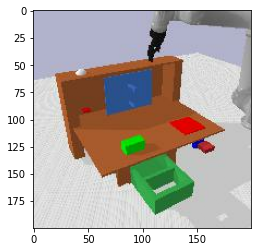

In [96]:
plt.imshow(img)